# Quantum Thermal State Preparation Algorithm Implementation

## Introduction

This implementation is based on the paper [[1](#Thermal)] and was written in collaboration with Chi-Fang (Anthony) Chen, the first author of the paper.

Quantum thermal state preparation is the task of preparing the Gibbs state [[2](#Gibbs)], which is the quantum state in a thermal equilibrium. In difference with ground state preparation, here one looks for properties of a quantum system which is coupled to an environment in a certain temperature. Besides simulating nature's behaviour, it is an algorithmic primitive that can be used within other quantum algorithms, such as for solving semi-definitie programs [[3](#SDP)].

Formaly, the Gibbs state is a mixed-state, and defined as:

$$
\sigma_\beta := \frac{e^{-\beta H}}{Z} \propto \sum_i e^{-\beta E_i} |\psi_i\rangle\langle \psi_i|, \quad
Z := \operatorname{tr}\bigl[e^{-\beta H}\bigr].
$$
Notice that since the state is a mixed-state, we describe using a density matrix.


### Problem Definition

* **Input:**

    * $H$: Hamiltonian of a system; Can be a pauli decomposition, block encoding or a function that efficiently implements $e^{-iHt}$.
    * $\beta$: Inverse-temperature of the system.



* **Output:**

    * A state $\rho$ which is an $\epsilon$-approximation of the Gibbs state:$\|\rho - \sigma_\beta\|_{\text{tr}} \le \epsilon$ where $\|\cdot\|_{\text{tr}}$ denotes the trace distance.

## Algorithm Description

The algorithm is a quantum version of the classical Markov chain Monte Carlo (MCMC) algorithm [[4](#MCMC)]. It is composed of the following steps:

1. Apply a random jump\transformation on the state from a set of jumps $A$ (usually a local transformation, but not necessarily).
2. Measure the energy difference $\Delta\omega$. 
3. Accept the jump with probability that is propotional to $e^{-\beta\Delta\omega}$, otherwise reject the step and revert to the original state.

Instead of taking discrete jumps, it is possible to simulate a continous case by simulating evolution under a generator matrix (Laplacian $L$ in the classical case, Linbladian $\mathcal{L}$ [[5](#Linbladian)] in the quantum case). So the quantum algorithm is just a quantum simulation of a block-encoded Linbladian, which is designed to have a fixed point approximately at the Gibbs state. Any Linbladian can be written in the following form:
$$
\mathcal{L}(\rho) = 
\underbrace{-i \left[ H, \rho \right]}_{\substack{\text{Coherent (unitary)} \\ \text{dynamics}}}
+ 
\underbrace{\sum_k \left( L_k \rho L_k^\dagger - \frac{1}{2} \left\{ L_k^\dagger L_k, \rho \right\} \right)}_{\substack{\text{Dissipative (non-coherent)} \\ \text{dynamics}}}
$$
where the evolution is according to:
$$\rho(t) = e^{t \mathcal{L}_\beta} \, \rho(0)$$
with $L_k$ being the Linblad (jump) operators. The algorithm engineers a Linbladian that consists only of dissipative terms. Each term $\hat{A}_a(\bar{\omega})$ is the Fourier transform of a jump operator in $A$:
$$
\mathcal{L}_\beta(\rho) := \sum_{\substack{a \in \mathcal{A},\\ \bar{\omega} \in S_{\omega_0}}} \gamma(\bar{\omega}) \left(
\hat{A}_a(\bar{\omega})\, \rho \, \hat{A}_a(\bar{\omega})^\dagger - \frac{1}{2} \left\{ \hat{A}_a(\bar{\omega})^\dagger \hat{A}_a(\bar{\omega}),\, \rho \right\}
\right)
$$

### Challenges
There are 2 main challenges in translating the classical monte carlo to a quantum version:
1. Energy uncertainty: measuring the energy with high resolution is with exponential cost due to energy-time uncertainty.
2. Rejection step: it turns out that rejecting is not trivial, as the accept involves measurements.
   
In order to deal with the first problem, the algorithm presentes the Operator Fourier Transform primitive, which estimates smoothly the energy difference, in a way that gurantees to reach approximated detailed balance [[6](#DetailedBalance)]. In order to tackle the second problem, the algorithm takes advatange of mid-circuit measurements and the quantum Zeno effect [[7](#ZENO)], which turns out to work well with the Linbladian simulation.

### Running Time
The total simulation time will be $O\left( \frac{\beta t_{mix}^2(\beta)}{\epsilon} \right)$, where $t_{mix}(\beta)$ is the mixing time of the Linbladian, measuring the time it takes to different mixed states to be indistinguishable under the evolution of $\mathcal{L}$. The mixing time is not trivial to calculate, and can be estimated in certain cases, such as [[8](#RapidMixingTime)].


The algorithm might give exponential advantage for quantum systems that thermalize fast enough and have the sign problem [[9](#SignProblem)] so that no efficient classical alternatives exist.

## Algorithm implementation with Classiq

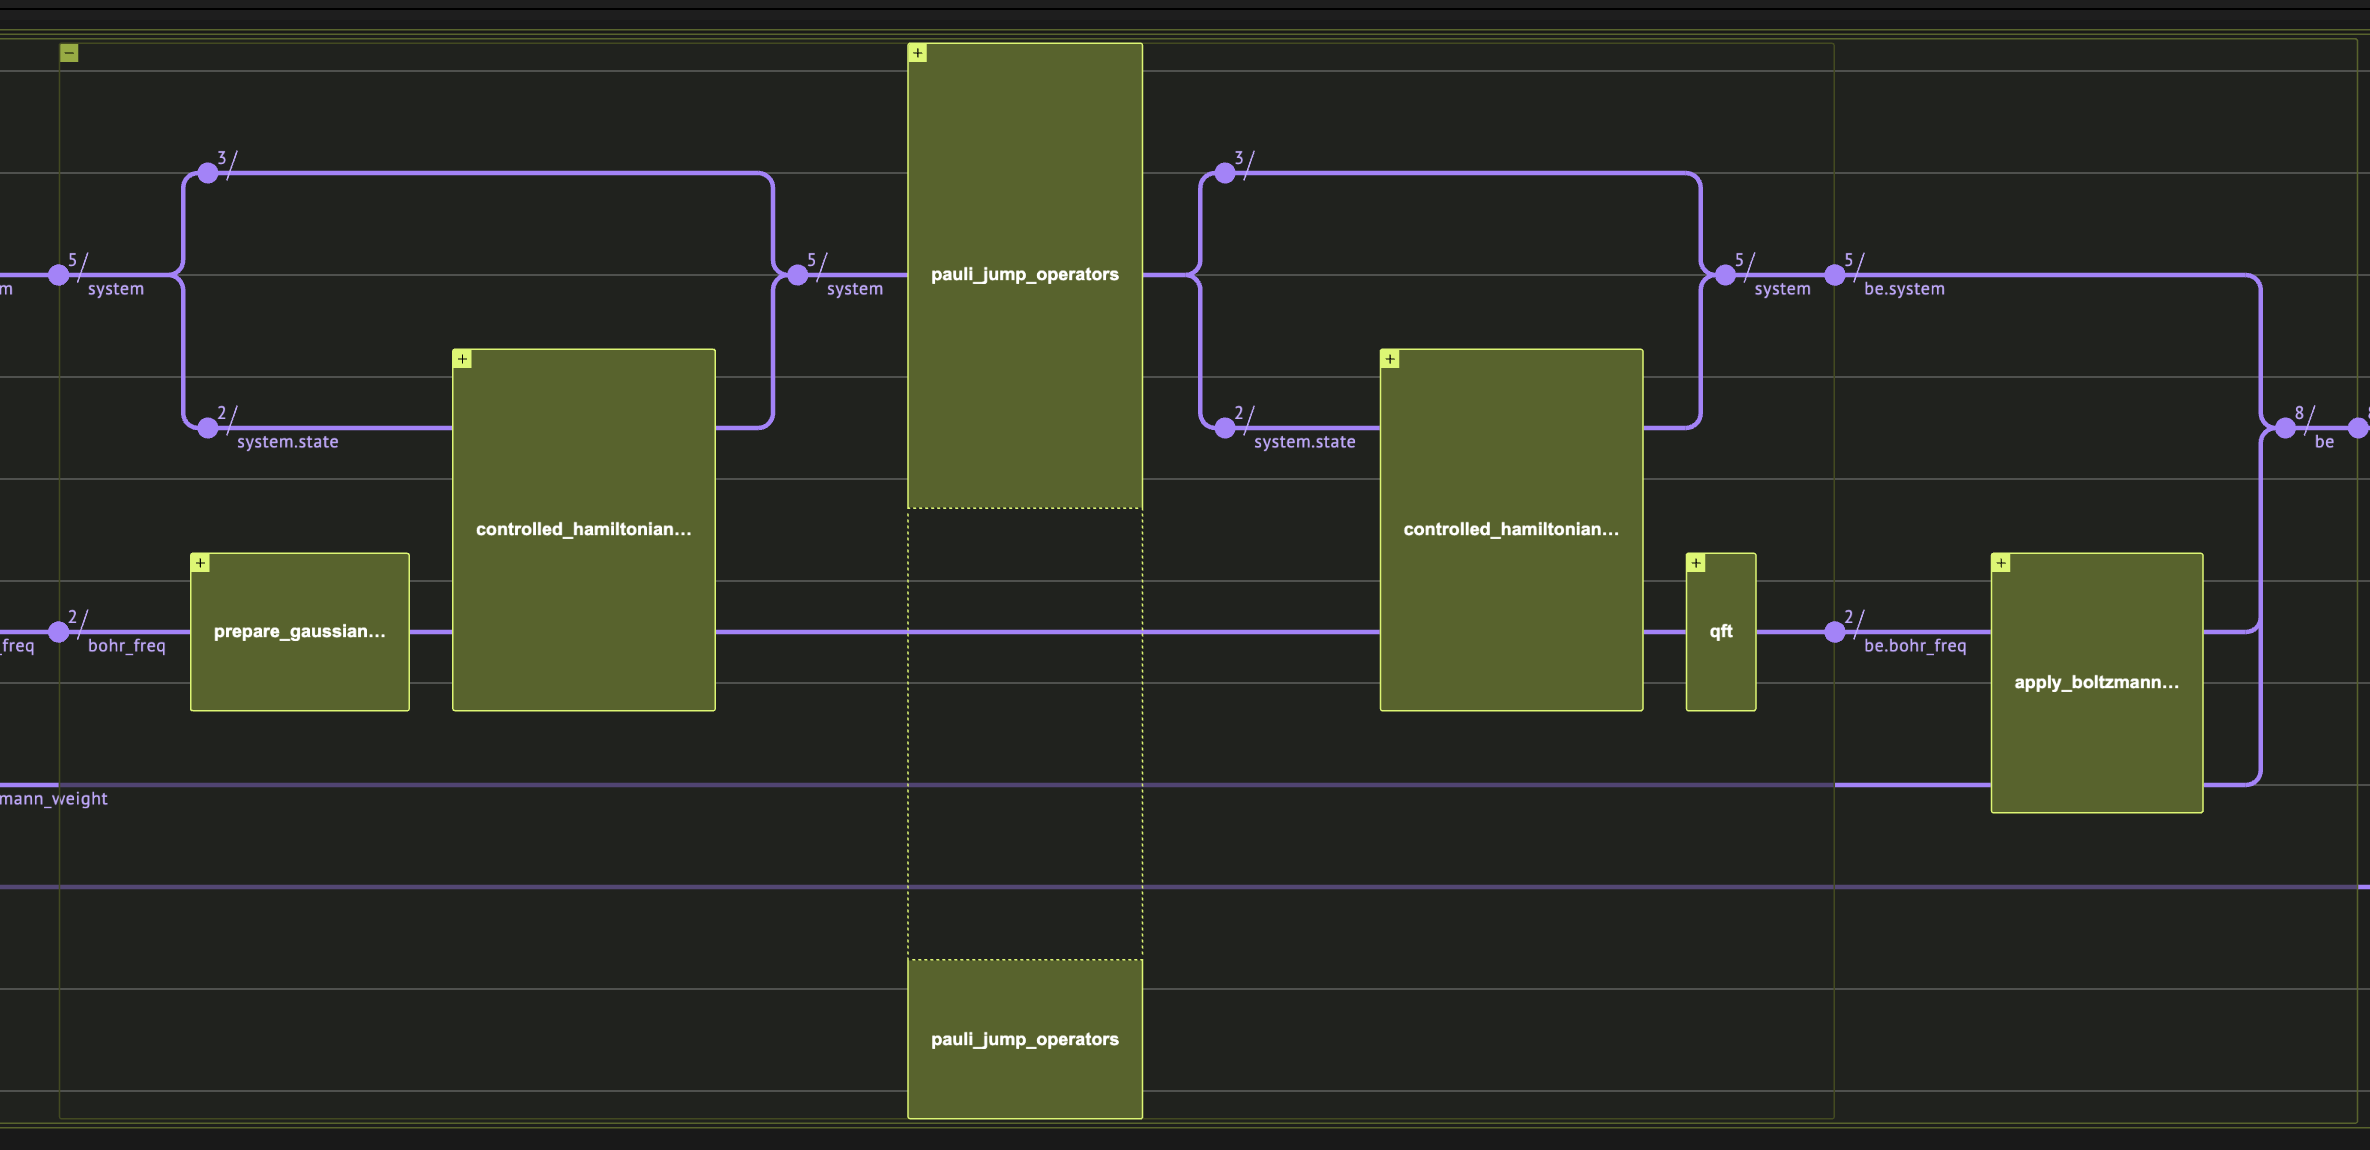
**Figure 1:** A snippet for a quantum circuit for the Quantum Thermal State Preparation algorithm, as produced by the classiq platform.

### Toy problem setting

Here we define a very basic problem with just 2 qubits, and a diagonal hamiltonian, so that we will be able to implement the hamiltonian simulation exactly, and get results within the quantum simulator limits. We note that the algorithm does not gurantee improvement over classical monte carlo in the case of such hamiltonian, and we choose it for a didactic reason.

The hamiltonian will be $H = Z_1 Z_2 + Z_1 I =
\begin{pmatrix}
2 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & -2 & 0 \\
0 & 0 & 0 & 0
\end{pmatrix}$.

The second parameter for the problem is $\beta = \frac {1}{T}$. Here we choose quite small value for fast convergence.

In [1]:
import numpy as np

from classiq import *

# Problem:
HAMILTONIAN = [
    PauliTerm(pauli=[Pauli.Z, Pauli.Z], coefficient=1),
    PauliTerm(pauli=[Pauli.Z, Pauli.I], coefficient=1),
]
SYSTEM_SIZE = len(HAMILTONIAN[0].pauli)
MAX_ENERGY_SHIFT = 4  # a bound on the energy shift, to normalize the hamiltonian by

BETA = 0.2

### Operator Fourier Transform

This is the heart of the algorithm. This building block is quite similar to the Quantum Phase Estimation. However, there are 2 main differences:
- The initial state prepared for the phase register is a Gaussian distribution instead of a uniform one. It is used in order to have better guarantees on the error of the estimated energy. It is required because the time window is limited.
- The circuit is measuring the energy difference that the operator is doing on eigenvalues instead of just the energy of each eigenvalue in superposition.

For example, take an operator $O$ and hamiltoanian $H$ with eigenvalues $|\lambda_i\rangle$. If for $O$ and $|\lambda_0\rangle$ it holds that $O|\lambda_0\rangle = |\lambda_1\rangle + |\lambda_2\rangle$, then the output of the circuit for the input $|\lambda_0\rangle|0\rangle$ will be approximately: $|\lambda_1\rangle|\omega_1 - \omega_0\rangle + |\lambda_2\rangle|\omega_2 - \omega_0\rangle$.

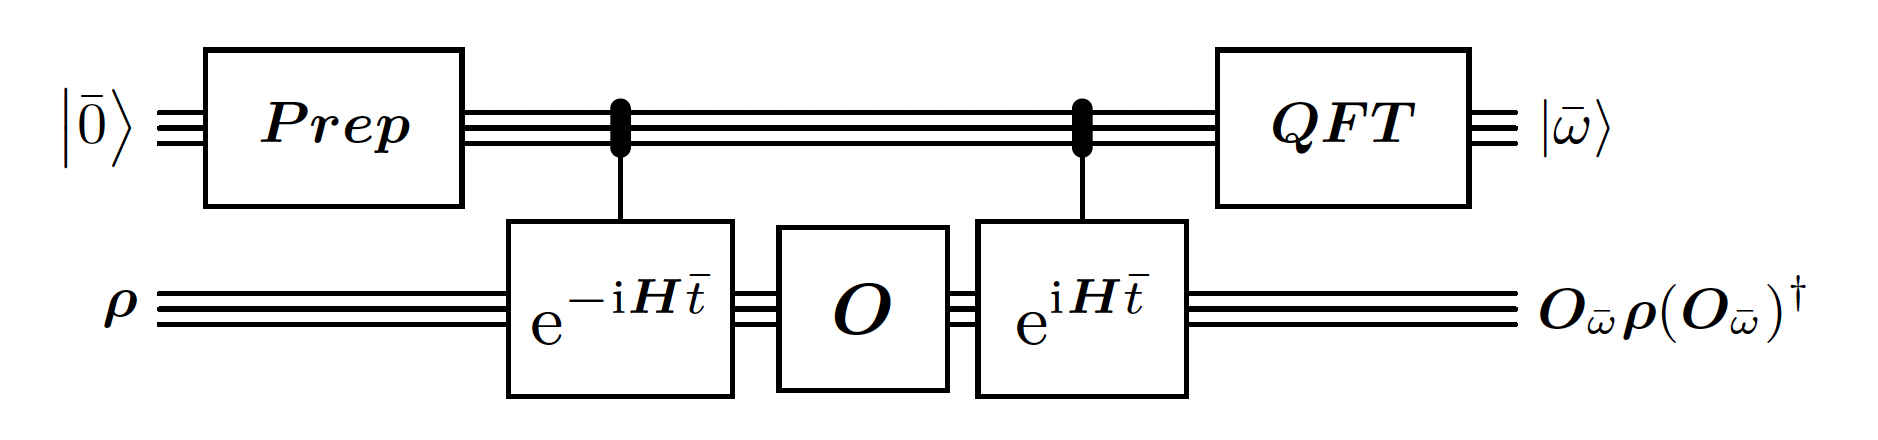
**Figure 2:** Circuit for Operator Fourier Transform for an operator $O$ acting on the state **$\rho$**, given hamiltonian $H$. Reproduced from [[1](#Thermal)] Fig. 5.

First we define a gaussian state preparation function. We choose truncation value and $\sigma$ in a quite arbitrary way now, qualitatively such that the gaussian trend will be within our truncation.

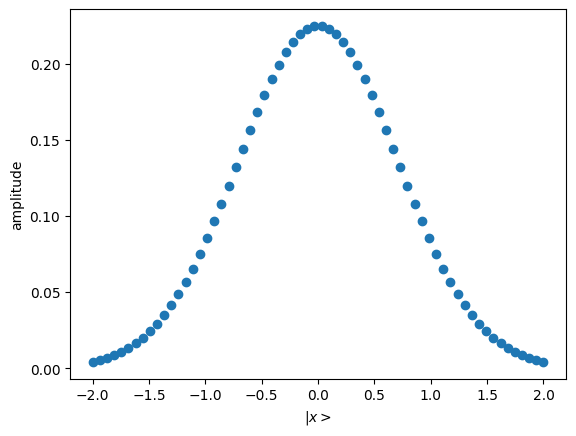

In [2]:
import matplotlib.pyplot as plt


def get_gaussian_amplitudes(num_qubits):
    grid = np.linspace(-2, 2, 2**num_qubits)
    amplitudes = np.exp(-(grid**2))
    amplitudes /= np.linalg.norm(amplitudes)
    return grid, amplitudes


@qfunc
def prepare_gaussian_state(t: QArray):
    grid, amplitudes = get_gaussian_amplitudes(t.len)
    inplace_prepare_amplitudes(amplitudes.tolist(), 0, t)


plt.scatter(*get_gaussian_amplitudes(6))
plt.xlabel("$|x>$")
plt.ylabel("amplitude");

In [3]:
@qfunc
def hamiltonian_simulation(hamiltonian: CArray[PauliTerm], time: CReal, state: QArray):
    suzuki_trotter(
        hamiltonian,
        evolution_coefficient=time,
        order=1,
        repetitions=1,  # we use just 1 repetition as we work with a diagonal hamiltonoan.
        qbv=state,
    )


@qfunc
def controlled_hamiltonian_simulation(
    hamiltonian: CArray[PauliTerm], t0: CReal, ctrl: QArray, state: QArray
):
    """
    A controlled powered hamiltonian simulation, as done in QPE of hamiltonian simulation
    """
    repeat(
        ctrl.len,
        lambda i: control(
            ctrl[i], lambda: hamiltonian_simulation(hamiltonian, 2**i * t0, state)
        ),
    )


@qfunc
def operator_fourier_transform(
    hamiltonian: CArray[PauliTerm],
    t0: CReal,
    operator: QCallable[QArray],
    state: QArray,
    bohr_freq: QNum,
):
    prepare_gaussian_state(bohr_freq)
    within_apply(
        lambda: controlled_hamiltonian_simulation(hamiltonian, t0, bohr_freq, state),
        lambda: operator(state),
    )
    invert(lambda: qft(bohr_freq))

Identify the quantum variable `bohr_freq` as signed integer, $\omega = \omega_0 \cdot$ `bohr_freq` and $t = t_0 \cdot $ `bohr_freq`,
while $\omega_0t_0 = \frac{2\pi}{N}$. It is analogous to the phase variable in Quantum Phase Estimation.


Require that $||H|| \lt \frac{N}{2}{\omega_0}$, so that the energy estimation won't overflow. We also want to take advantage of the full resolution of the QFT, so we choose $\omega_0$ close to the bound.

In [4]:
def get_fourier_parameters(num_energy_qubits, max_energy_shift):
    w0 = (2 + 0.5) * max_energy_shift / (2**num_energy_qubits)
    t0 = 2 * np.pi / (w0 * (2**num_energy_qubits))
    return w0, t0

Lets see how it works for the initial state $|0\rangle_{state}|0\rangle_{freq}$ and the operator $O = H\otimes H$ (where the $H$ are hadamard gates operating on the state variable).
We expect jumps from the eigenvalue 2 to eigenvalues 0 and -2:

In [5]:
ENERGY_QUBITS = 6
w0, t0 = get_fourier_parameters(ENERGY_QUBITS, MAX_ENERGY_SHIFT)


@qfunc
def main(state: Output[QArray[SYSTEM_SIZE]], w: Output[QNum[ENERGY_QUBITS, SIGNED, 0]]):
    allocate(state)
    allocate(w)
    operator_fourier_transform(
        HAMILTONIAN, t0, lambda s: hadamard_transform(s), state, w
    )


qmod = create_model(
    main,
    preferences=Preferences(optimization_level=0),
    execution_preferences=ExecutionPreferences(num_shots=10000),
)
qprog = synthesize(qmod)
show(qprog)
res = execute(qprog).get_sample_result()

Quantum program link: https://platform.classiq.io/circuit/32pWF7FtAuB0u3g07eRAOX47YmG


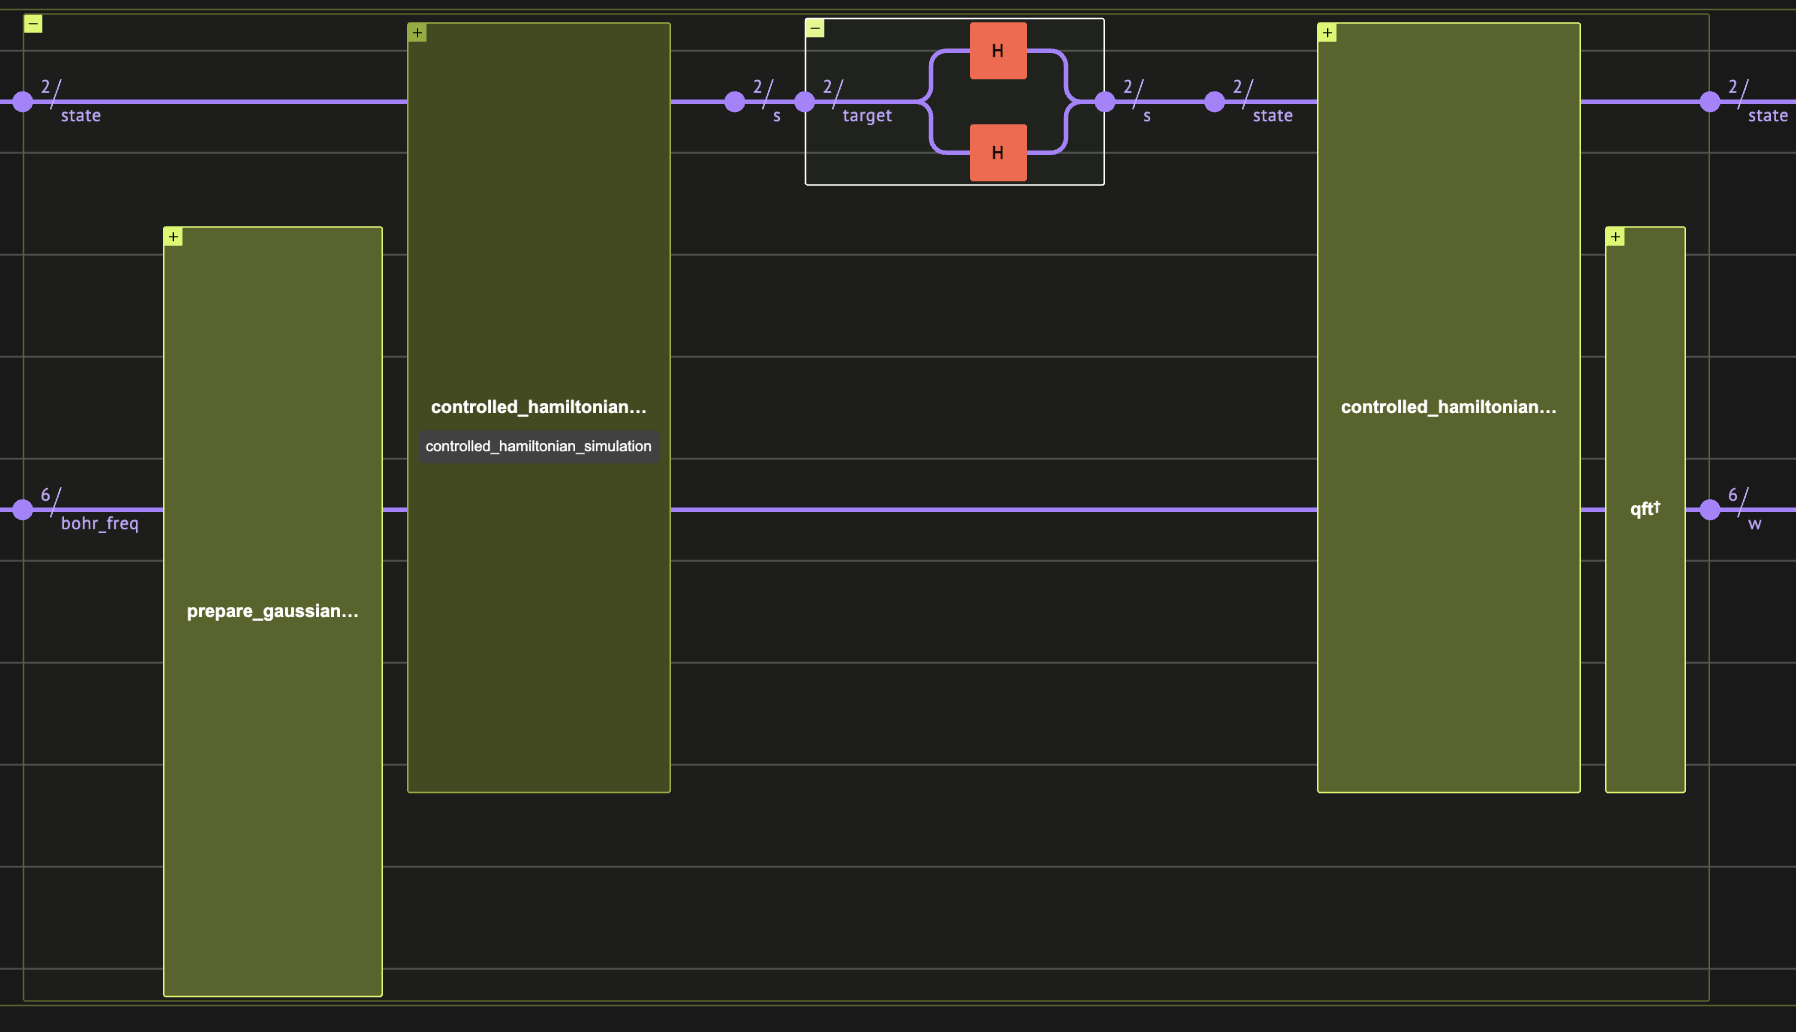
**Figure 3:** Circuit for Operator Fourier Transform for the operator $O = H\otimes H$ as produced by the classiq platform.

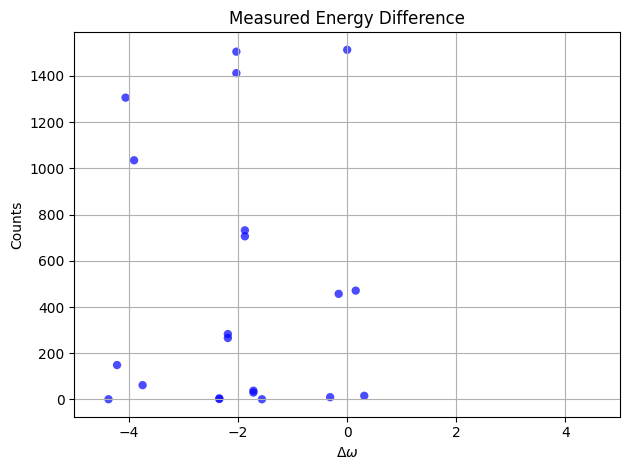

In [6]:
import matplotlib.pyplot as plt


def plot_omega_results(result):
    w = [sample.state["w"] for sample in result.parsed_counts]
    shots = [sample.shots for sample in result.parsed_counts]

    # Scale the w values
    w = np.array(w) * w0

    # Create the scatter plot.
    plt.scatter(w, shots, color="blue", alpha=0.7, edgecolors="none")
    plt.xlabel(r"$\Delta\omega$")
    plt.ylabel("Counts")
    plt.title("Measured Energy Difference")
    plt.grid(True)
    plt.xlim(-5, 5)
    plt.tight_layout()
    plt.show()


plot_omega_results(res)

Now see what happens if we use a uniform distribution instead of a gaussian one as the initial state for the `bohr_freq`:

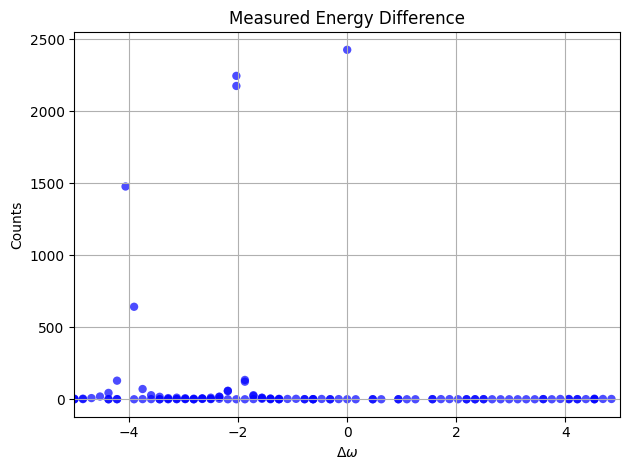

In [7]:
@qfunc
def operator_fourier_transform_uniform(
    hamiltonian: CArray[PauliTerm],
    t0: CReal,
    jump_operator: QCallable[QArray],
    state: QArray,
    bohr_freq: QNum,
):
    hadamard_transform(bohr_freq)  # uniform state preparation
    within_apply(
        lambda: controlled_hamiltonian_simulation(hamiltonian, t0, bohr_freq, state),
        lambda: jump_operator(state),
    )
    invert(lambda: qft(bohr_freq))


@qfunc
def main(state: Output[QArray[SYSTEM_SIZE]], w: Output[QNum[ENERGY_QUBITS, SIGNED, 0]]):
    allocate(state)
    allocate(w)
    operator_fourier_transform_uniform(
        HAMILTONIAN, t0, lambda s: hadamard_transform(s), state, w
    )


qmod = create_model(
    main,
    preferences=Preferences(optimization_level=0),
    execution_preferences=ExecutionPreferences(num_shots=10000),
)
qprog = synthesize(qmod)
res_uniform = execute(qprog).get_sample_result()
plot_omega_results(res_uniform)

Each peak is higher, but there is a longer tail, so it is harder to gurantee the accuracy of the scheme.

### Linbladian Block Encoding

First we pick jump operators that will define our Linbladian dissipative part. It is enough to choose local operators, so here we just use all possible single-site pauli operators.

In [8]:
# For better mixing and ergodicity, the jumps should be “scrambling” and not commute with the Hamiltonian
# (e.g., breaking the symmetries of the Hamiltonian).
# In our case it is enough to just take X jumps, but we do also Y for demonstration
JUMP_OPERATORS = [
    {"pauli": pauli, "index": index} for index in range(SYSTEM_SIZE) for pauli in [X, Y]
]

JUMP_VAR_SIZE = max(1, np.ceil(np.log2(len(JUMP_OPERATORS))))

Given a purely irreversible Linbladian:
$$
\mathcal{L}[\rho] := \sum_{j \in J} \Bigl( L_j\, \rho\, L_j^\dagger - \frac{1}{2}\, L_j^\dagger L_j\, \rho - \frac{1}{2}\, \rho\, L_j^\dagger L_j \Bigr),
$$

With Linbladian operators $L_j$, it is possible to block-encode it with $U$ such that:

$$
\Bigl( \langle 0_b | \otimes I \Bigr) \, U \, \Bigl( |0_c\rangle \otimes I \Bigr)
= \sum_{j \in J} |j\rangle \otimes L_j,
$$

In our case, each Linblad operator is effectively a fourier mode $\hat{A}_a(\bar{\omega})$ the operator Fourier transform of a pauli jump operator weighted by a boltzmann weight $\sqrt{\gamma(\bar{\omega})}$. 

$$ \hat{A}_a(\bar{\omega}) := \sum_{\bar{t} \in S_{t0}} e^{-i \bar{\omega} \bar{t}} f(\bar{t}) A_a(\bar{t}) \ \text{for each} \ a \in A, \ \bar{\omega} \in S_{\omega0}. $$

$$ (\langle0_b|\langle0|_{boltz.}\otimes I)U(|0_b\rangle|0\rangle_{boltz.}|0\rangle_{freq}|0\rangle_{jump}\otimes I) = \sum_{a \in A, \ \bar{\omega} \in S_{\omega0}} \sqrt{\gamma(\bar{\omega})} |\bar{\omega}, a\rangle \otimes \hat{A}_a(\bar{\omega}). $$

We implement it by doing a single call to operator Fourier transform, and apply it on a block encoding of all pauli jumps, followed by $Y$ rotation based on $\bar{\omega}$.

Here, we take $A=\{X_1, X_2, Y_1, Y_2\}$.

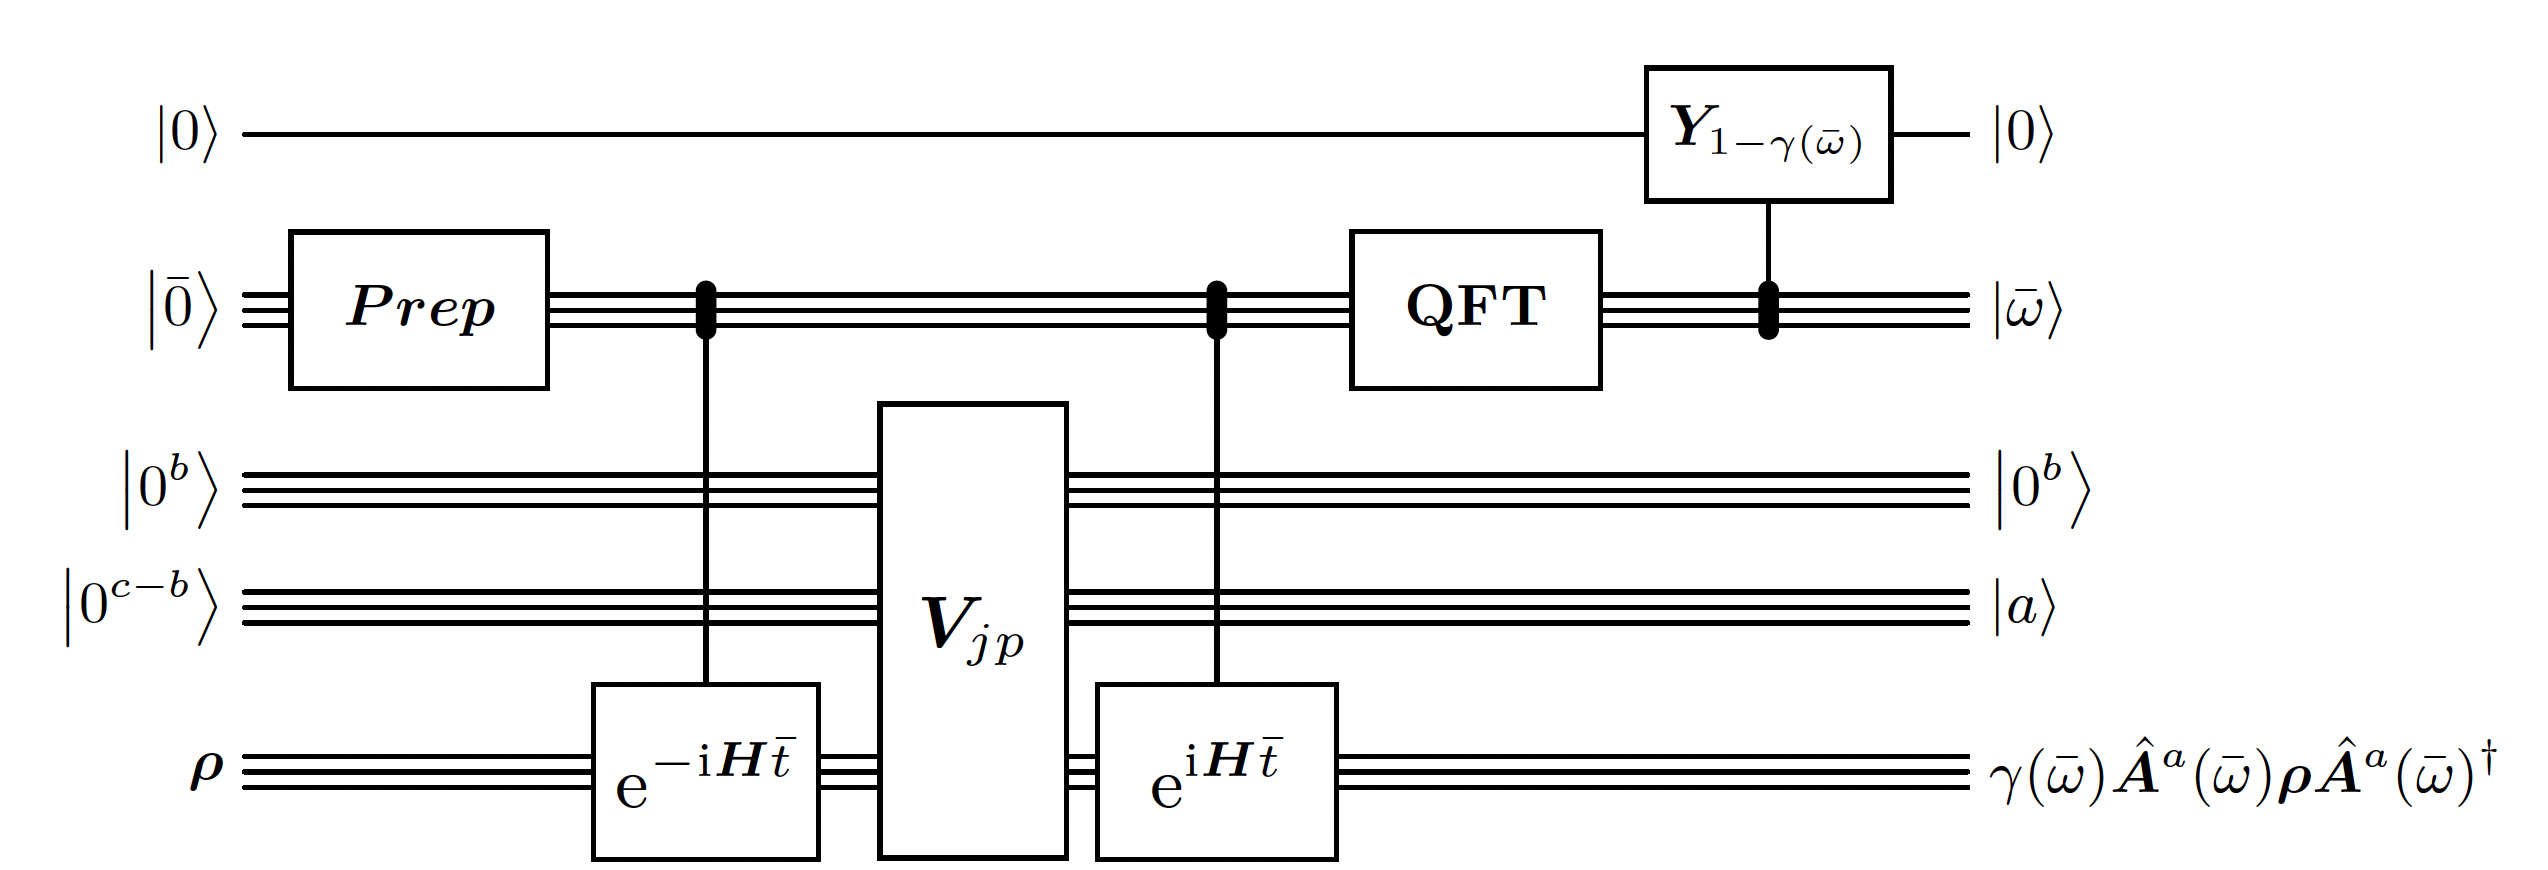
**Figure 4:** Circuit for block encoding the linbladian $\mathcal{L}$. Reproduced from [[1](#Thermal)] Fig. 4.

In [9]:
from classiq.qmod.symbolic import exp, min as qmin, pi, sqrt


class LinbladianBlock(QStruct):
    jump: QNum
    bohr_freq: QNum
    boltzmann_weight: QBit


class BlockEncodedLinbladianState(QStruct):
    block: LinbladianBlock
    state: QArray


@qfunc
def pauli_jump_operators(jump: QNum, state: QArray):
    prepare_uniform_trimmed_state(len(JUMP_OPERATORS), jump)
    for index, jump_op in enumerate(JUMP_OPERATORS):
        control(jump == index, lambda: jump_op["pauli"](state[jump_op["index"]]))


@qfunc
def apply_boltzmann_weight(
    beta: CReal, w0: CReal, bohr_freq: QNum, boltzmann_weight: QBit
):
    # glauber
    boltzmann_weight *= sqrt(1 / (exp(beta * w0 * bohr_freq) + 1))

    # metropolis
    # boltzmann_weight *= qmin(1, exp(-beta * w0 * bohr_freq))

    # adjust conventions so that sqrt(gamma(w)) will be the amplitude of |0>
    X(boltzmann_weight)


@qfunc
def block_encode_linbladian(
    hamiltonian: CArray[PauliTerm],
    beta: CReal,
    w0: CReal,
    be: BlockEncodedLinbladianState,
):
    operator_fourier_transform(
        hamiltonian,
        2 * pi / (w0 * (2**be.block.bohr_freq.size)),
        lambda _state: pauli_jump_operators(be.block.jump, _state),
        be.state,
        be.block.bohr_freq,
    )
    apply_boltzmann_weight(beta, w0, be.block.bohr_freq, be.block.boltzmann_weight)

### Linbladian Evolution of a $\delta$-time step

Given our block encoding $U$, and assuming that the Linbladian is purely irreversible, it is possible to evolve it for a timestep using a 1st order approximation: $I + \delta\mathcal{L} + \mathcal{O}(\delta^2)$ using weak measurements (weak measurement is a measurement that reveals only small amount of information on the system, and does not collapse entirely the state).  Actually the it exploits a quantum Zeno-like effect [[7](#ZENO)] that makes the corrections to the evolution on quadratic in $\delta$!

Note: This method is the 1st order approximation of the evolution. There are better scaling methods with higher order approximation to simulate the evolution of the Linbladian (see Appendix. F in the [[1](#Thermal)]).

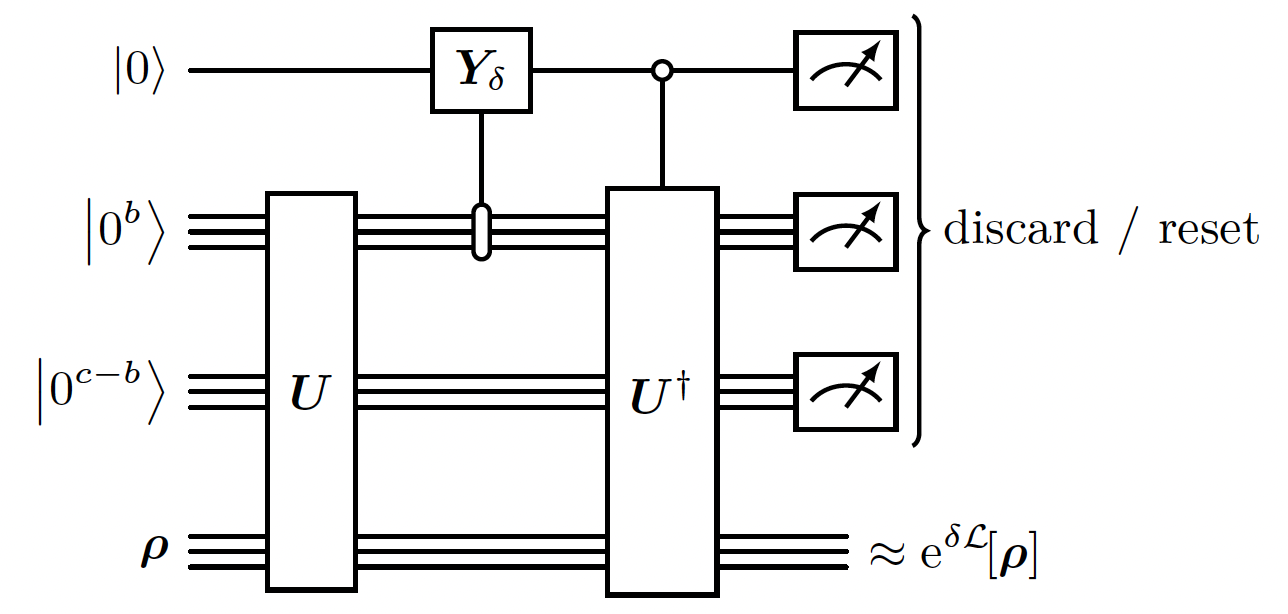
**Figure 5:** Circuit for an approximate $\delta$-time step evolution of the linbladian $\mathcal{L}$. Reproduced from [[1](#Thermal)] Fig. 3.

We use the `RESET` function to reset the state of a single qubit (thus saving qubits). Note that by using it, the circuit is not coherent anymore. The reset\discard operations act like nature's heat bath.

In [10]:
from classiq.qmod.symbolic import asin


@qfunc
def reset_var(qvar: QArray):
    apply_to_all(RESET, qvar)


@qfunc
def delta_step(
    hamiltonian: CArray[PauliTerm],
    beta: CReal,
    w0: CReal,
    delta: CReal,
    delta_qbit: QBit,
    be: BlockEncodedLinbladianState,
):
    block_encode_linbladian(hamiltonian, beta, w0, be)

    # the jump operators don't use block-encoding, hence only the boltzmann qbit will
    # flag an accepted jump
    control(
        be.block.boltzmann_weight == 0, lambda: RY(asin(2 * sqrt(delta)), delta_qbit)
    )
    control(
        delta_qbit == 0,
        lambda: invert(lambda: block_encode_linbladian(hamiltonian, beta, w0, be)),
    )

    reset_var(be.block)
    reset_var(delta_qbit)

## Running The algorithm

We choose parameters for the energy evaluation in the operator Fourier transform, a small enough delta timestep and number of repetitions. Note that as we make `DELTA` small enough, the approximation of evolution will be better. As the `MAX_REPETIOTIONS` * `DELTA` (total simulation time) is larger, the state is better mixed and we get closer to the approximated detailed balance state.
As `FT_WINDOW_SIZE` is larger, the approximated detailed balance state gets closer to the desired detailed balance state.

Here we choose parameters that will allow reasonable simulation time on a quantum simulator. Note that as the algorithm includes mid-circuit measurements, the runtime time of state-vector simulators scales linearly with the number of shots. If a high number of shots is required, it might be beneficial to use the density matrix simulator instead.

In [11]:
DELTA = 0.1
NUM_REPETITIONS = 50


FT_WINDOW_SIZE = 4
W0, T0 = get_fourier_parameters(FT_WINDOW_SIZE, MAX_ENERGY_SHIFT)


class LinbladianBlock(QStruct):  # naming corresponds to the paper p.23
    jump: QNum[
        JUMP_VAR_SIZE, UNSIGNED, 0
    ]  # jump operators label for the block encoding
    bohr_freq: QNum[
        FT_WINDOW_SIZE, SIGNED, 0
    ]  # frequency register for the Operator Fourier Transform
    boltzmann_weight: QBit  # ancilla for storing the Bohr-frequency dependent Boltzmann weights in the amplitudes


class BlockEncodedLinbladianState(QStruct):
    block: LinbladianBlock
    state: QArray[QBit, SYSTEM_SIZE]  # holds the state of the system

The initial state can be in general any state. As the initial state is closer to the thermal state, the mixing time should be smaller. In case there is more than one minima, it might be beneficial to start with the maximally mixed state.

In [12]:
@qfunc
def main(be: Output[BlockEncodedLinbladianState]):
    delta_qbit = QBit()

    allocate(be)
    allocate(delta_qbit)

    # start with the |00> state

    repeat(
        NUM_REPETITIONS,
        lambda i: delta_step(HAMILTONIAN, BETA, W0, DELTA, delta_qbit, be),
    )
    drop(delta_qbit)


execution_preferences = ExecutionPreferences(
    num_shots=1000,
    # backend_preferences=ClassiqBackendPreferences(backend_name="simulator_density_matrix"), # slow, use when number of shots is very high
    backend_preferences=ClassiqBackendPreferences(backend_name="simulator"),
)

qmod = create_model(
    main,
    preferences=Preferences(optimization_level=0),
    execution_preferences=execution_preferences,
)
qprog = synthesize(qmod)
print("synthesized")
show(qprog)

synthesized
Quantum program link: https://platform.classiq.io/circuit/32pWSnNqJ7rFHg9MSt4FlcqpWzH


In [13]:
res = execute(qprog).get_sample_result()
res.parsed_counts

[{'be': {'block': {'jump': 0, 'bohr_freq': 0, 'boltzmann_weight': 0}, 'state': [0, 1]}}: 353,
 {'be': {'block': {'jump': 0, 'bohr_freq': 0, 'boltzmann_weight': 0}, 'state': [1, 0]}}: 248,
 {'be': {'block': {'jump': 0, 'bohr_freq': 0, 'boltzmann_weight': 0}, 'state': [1, 1]}}: 222,
 {'be': {'block': {'jump': 0, 'bohr_freq': 0, 'boltzmann_weight': 0}, 'state': [0, 0]}}: 177]

Lastly, we verify the results against the expected Gibbs distribution:

In [14]:
samples = dict(
    (int("".join(map(str, reversed(s.state["be"].state))), 2), s.shots)
    for s in res.parsed_counts
)
measured_probs = np.array([v for k, v in sorted(samples.items())])
measured_probs = measured_probs / sum(measured_probs)
measured_probs

array([0.177, 0.248, 0.353, 0.222])

In [15]:
eigs = [2, 0, -2, 0]
expected_probs = [np.exp(-eig * BETA) for eig in eigs]
expected_probs /= sum(expected_probs)
expected_probs

array([0.16105159, 0.24026075, 0.35842691, 0.24026075])

In [16]:
assert np.allclose(measured_probs, expected_probs, atol=0.1)

## Notes:

1. **Exact detailed balance**: astonishingly, in a followup paper [[10](#Exact)] the authors improved the algorithm to reach exact detailed balance instead of approximated, still with finite time hamiltonian simulation. They use Linbladian with a coherent term as well. The algorithm runtime then scales as $O\left( \beta \cdot t_{mix}(\beta) \right)$. 
2. **Block Encoding vs. Sampling Jumps**: it is possible and equivalent to classicaly sample jump operator on each iteration of the algorithm, instead of block encoding all the jumps as we did in the implementation.
3. **Coherent version**: the paper also presents a purified version of the algorithm, that improves quadratically the run time.

## References

<a id='Thermal'>[1]</a>: [Chen, C.-F., Kastoryano, M. J., Brandão, F. G. S. L., & Gilyén, A. (2023). *"Quantum Thermal State Preparation"*](https://arxiv.org/abs/2303.18224)

<a id='Gibbs'>[2]</a>: [Gibbs State (Wikipedia)](https://en.wikipedia.org/wiki/Gibbs_state)

<a id='SDP'>[3]</a>: [Brand˜ao, F. G. S. L. and Svore, K. M. *“Quantum Speed-ups for Solving Semidefinite Programs.”* In:FOCS (2017), 415–426.
](https://arxiv.org/abs/1609.05537)

<a id='MCMC'>[4]</a>: [Markov Chain Monte Carlo (Wikipedia)](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)

<a id='Linbladian'>[5]</a>: [Linbladian (Wikipedia)](https://en.wikipedia.org/wiki/Lindbladian) 

<a id='DetailedBalance'>[6]</a>: [Detailed balance (Wikipedia)](https://en.wikipedia.org/wiki/Detailed_balance) 

<a id='ZENO'>[7]</a>: [Quantum Zeno Effect (Wikipedia)](https://en.wikipedia.org/wiki/Quantum_Zeno_effect)

<a id='RapidMixingTime'>[8]</a> [Ivan Bardet, ´Angela Capel, Li Gao, Angelo Lucia, David P´erez-Garc´ıa, and Cambyse Rouz´e. *"Rapid thermalization of spin chain commuting hamiltonians. Physical Review Letters, 130(6):060401, 2023.*](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.130.060401)


<a id='SignProblem'>[9]</a>: [Numerical sign problem (Wikipedia)](https://en.wikipedia.org/wiki/Numerical_sign_problem)

<a id='Exact'>[10]</a>: [Chen, C.-F., Kastoryano, M. J., & Gilyén, A. (2023). *"An efficient and exact noncommutative quantum Gibbs sampler"*
](https://arxiv.org/abs/2311.09207)
